# Analyzing NYC's Stormwater Flood Map - Extreme Flood Scenario
## Data Cleaning

Mark Bauer

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import zipfile 
import matplotlib.patches as mpatches
import contextily as ctx

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,seaborn,matplotlib,geopandas

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.22.4
pandas    : 1.4.2
seaborn   : 0.11.2
matplotlib: 3.5.2
geopandas : 0.9.0



![nyc-opendata-dashboard](images/nyc-opendata-dashboard.png)

Source: https://data.cityofnewyork.us/City-Government/NYC-Stormwater-Flood-Map-Extreme-Flood-with-2080-S/w8eg-8ha6

In [3]:
# download data from nyc open data using urllib

# url path from the web
url = 'https://data.cityofnewyork.us/download/w8eg-8ha6/application%2Fzip'
file_name = 'data/stormwater-data-nyc.zip'

# assigning file name as 'stormwater-data-nyc.zip''
urllib.request.urlretrieve(url, file_name)

%ls data/

stormwater-data-nyc.zip


In [4]:
path = 'data/stormwater-data-nyc.zip'
directory = 'data/stormwater-data-source'

# extracting items in zip folder
with zipfile.ZipFile(path, 'r') as file:
    # extracing all items in our zipfile
    file.extractall(directory)

%ls data/stormwater-data-source/    

NYC Stormwater Flood Map - Extreme Flood with 2080 Sea Level Rise.gdb/
NYC Stormwater Flood Map - Extreme Flood with 2080 Sea Level Rise.xlsx


In [5]:
# copy data dictionary to top-level repository directory
!cp 'data/stormwater-data-source/NYC Stormwater Flood Map - Extreme Flood with 2080 Sea Level Rise.xlsx' .

%ls

CONTRIBUTING.md
LICENSE
NYC Stormwater Flood Map - Extreme Flood with 2080 Sea Level Rise.xlsx
README.md
analysis.ipynb
data/
data-cleaning.ipynb
figures/
images/


In [6]:
# reading in data
path = 'data/stormwater-data-source/NYC Stormwater Flood Map - Extreme Flood with 2080 Sea Level Rise.gdb'
gdf = gpd.read_file(path)

print('shape of data: {}'.format(gdf.shape))
gdf.head()

shape of data: (3, 4)


,Flooding_Category,Shape_Length,Shape_Area,geometry
0,1,3.264384e+07,3.972152e+08,"MULTIPOLYGON Z (((917206.497 120931.611 0.000,..."
1,2,1.656489e+07,3.054550e+08,"MULTIPOLYGON Z (((917270.790 120873.747 0.000,..."
2,3,8.042525e+06,3.455846e+08,"MULTIPOLYGON Z (((915290.556 120269.389 0.000,..."


In [7]:
# summary of the data
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Flooding_Category  3 non-null      int64   
 1   Shape_Length       3 non-null      float64 
 2   Shape_Area         3 non-null      float64 
 3   geometry           3 non-null      geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 224.0 bytes


In [8]:
# examine crs
gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

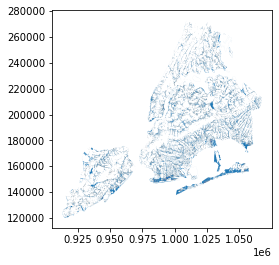

In [9]:
# examine plot
gdf.plot()

In [10]:
# examine flood category codes
gdf.head()

,Flooding_Category,Shape_Length,Shape_Area,geometry
0,1,3.264384e+07,3.972152e+08,"MULTIPOLYGON Z (((917206.497 120931.611 0.000,..."
1,2,1.656489e+07,3.054550e+08,"MULTIPOLYGON Z (((917270.790 120873.747 0.000,..."
2,3,8.042525e+06,3.455846e+08,"MULTIPOLYGON Z (((915290.556 120269.389 0.000,..."


Flooding_Category	
Category of flooding classified by depth of ponding or tidal inundation from sea level rise

>1 - Nuisance Flooding (greater or equal to 4 in. and less than 1 ft.)  
2 - Deep and Contiguous Flooding (1 ft. and greater)  
3 - Future High Tides 2080

In [11]:
# mapping flood category codes to classifications
gdf['flood_classification'] = (
    gdf['Flooding_Category'].replace(
        {1:'Nuisance Flooding',
         2:'Deep and Contiguous Flooding',
         3:'Future High Tides 2080'})
)

print('shape of data: {}'.format(gdf.shape))
gdf.head()

shape of data: (3, 5)


,Flooding_Category,Shape_Length,Shape_Area,geometry,flood_classification
0,1,3.264384e+07,3.972152e+08,"MULTIPOLYGON Z (((917206.497 120931.611 0.000,...",Nuisance Flooding
1,2,1.656489e+07,3.054550e+08,"MULTIPOLYGON Z (((917270.790 120873.747 0.000,...",Deep and Contiguous Flooding
2,3,8.042525e+06,3.455846e+08,"MULTIPOLYGON Z (((915290.556 120269.389 0.000,...",Future High Tides 2080


In [12]:
# examine geometries
gdf['geometry'].geom_type

0    MultiPolygon
1    MultiPolygon
2    MultiPolygon
dtype: object

In [13]:
# explode dictionary so every row is a polygon
gdf = (
    gdf
    .explode()
    .reset_index(drop=True)
)

# calculating are and length of geometries
gdf['Shape_Area'] = gdf.area 
gdf['Shape_Length'] = gdf.length 

print('shape of data: {}'.format(gdf.shape))
gdf.head()

shape of data: (145429, 5)


,Flooding_Category,Shape_Length,Shape_Area,flood_classification,geometry
0,1,51.436905,165.359700,Nuisance Flooding,"POLYGON Z ((917206.497 120931.611 0.000, 91720..."
1,1,37.622059,79.460913,Nuisance Flooding,"POLYGON Z ((917309.366 120950.899 0.000, 91730..."
2,1,14.432754,4.925173,Nuisance Flooding,"POLYGON Z ((917309.366 120950.899 0.000, 91730..."
3,1,54.817201,154.010850,Nuisance Flooding,"POLYGON Z ((917277.219 120938.040 0.000, 91726..."
4,1,24.392395,14.030167,Nuisance Flooding,"POLYGON Z ((917311.973 120963.757 0.000, 91730..."


In [14]:
# examine count of polygons by flood classifications
(gdf
 .groupby(by='flood_classification')[['flood_classification']]
 .count()
 .rename(columns={'flood_classification':'count_polygons'})
)

,count_polygons
flood_classification,
Deep and Contiguous Flooding,39742
Future High Tides 2080,7122
Nuisance Flooding,98565


In [15]:
# examine flooded area by flood classifications

acres_conversion = 43560

(gdf
 .groupby(by='flood_classification')[['Shape_Area']]
 .sum()
 .div(acres_conversion)
 .round(0)
 .astype(int)
 .rename(columns={'Shape_Area':'shape_area_acres'})
)

,shape_area_acres
flood_classification,
Deep and Contiguous Flooding,7012
Future High Tides 2080,7934
Nuisance Flooding,9119


In [16]:
# save file
gdf.to_file(
    'data/stormwater-data.gpkg',
    driver='GPKG',
    layer='name',
    index=False
)

%ls data/

stormwater-data-nyc.zip  stormwater-data-source/  stormwater-data.gpkg


In [17]:
# zip .gpkg into zip folder
!zip data/stormwater-data.zip data/stormwater-data.gpkg

%ls data/

  adding: data/stormwater-data.gpkg (deflated 62%)
stormwater-data-nyc.zip  stormwater-data.gpkg
stormwater-data-source/  stormwater-data.zip


In [18]:
# remove copies of data to save storage
!rm data/stormwater-data.gpkg data/stormwater-data-nyc.zip

%ls data/

stormwater-data-source/ stormwater-data.zip
